In [10]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

from src.modeling import prepare_modeling_data, pre_processing, optuna_tune_model
from src.Model_evaluation import evaluate_model, model_comparison


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
X_train, X_test, y_train, y_test, features = prepare_modeling_data('../Data/final/telecom_churn_features.csv')
y_train.value_counts(normalize=True)

In [ ]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test)

In [ ]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

In [ ]:

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)


In [ ]:
evaluate_model(gbc, X_test, y_test)

In [ ]:

models={
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Gradient Boosting": gbc
}
model_comparison(models, X_test, y_test)

# Time series Split

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

from src.modeling import pre_processing

X,X_test,y,y_test = pre_processing('../Data/final/telecom_churn_features.csv')
model = GradientBoostingClassifier()
ohe = OneHotEncoder(use_cat_names=True)
ss = StandardScaler()
scores = []
tscv = TimeSeriesSplit(n_splits=4)
for train_idx, test_idx in tscv.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
    # Train and evaluate your model here
    
    X_tr = ohe.fit_transform(X_tr)
    X_val = ohe.transform(X_val)

    X_tr = ss.fit_transform(X_tr)
    X_val = ss.transform(X_val)

    model.fit(X_tr, y_tr)
    y_pred = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, y_pred))
print("Time Series CV-4 AUC Scores:", scores)

In [ ]:
import numpy as np
print("Mean AUC:", np.mean(scores))

In [ ]:


X,X_train,y,y_train = pre_processing('../Data/final/telecom_churn_features.csv')
study_rf = optuna_tune_model(X, y, model_type="random_forest", n_trials=10)
study_gbm = optuna_tune_model(X, y, model_type="gradient_boosting", n_trials=10)

print("Best RF params:", study_gbm.best_params)
print("Best GBM params:", study_rf.best_params)


[I 2025-10-09 16:53:58,523] A new study created in memory with name: no-name-9eafb380-aa37-4350-b52e-df8f9243081f
[I 2025-10-09 16:55:01,546] Trial 0 finished with value: 0.9999999377399347 and parameters: {'n_estimators': 676, 'max_depth': 29, 'min_samples_split': 8}. Best is trial 0 with value: 0.9999999377399347.
[I 2025-10-09 16:55:39,799] Trial 1 finished with value: 0.9999999377399347 and parameters: {'n_estimators': 401, 'max_depth': 14, 'min_samples_split': 2}. Best is trial 0 with value: 0.9999999377399347.
[I 2025-10-09 16:57:17,683] Trial 2 finished with value: 0.9999999252879217 and parameters: {'n_estimators': 883, 'max_depth': 15, 'min_samples_split': 5}. Best is trial 0 with value: 0.9999999377399347.
[I 2025-10-09 16:58:10,465] Trial 3 finished with value: 0.9999999377399347 and parameters: {'n_estimators': 541, 'max_depth': 9, 'min_samples_split': 4}. Best is trial 0 with value: 0.9999999377399347.
[I 2025-10-09 16:59:36,757] Trial 4 finished with value: 0.999999925287

Best RF params: {'learning_rate': 0.03654940437222579, 'n_estimators': 741, 'max_depth': 3}
Best GBM params: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 10}


In [8]:
X_train, X_test, y_train, y_test = pre_processing('../Data/final/telecom_churn_features.csv')
final_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    GradientBoostingClassifier(
        n_estimators=147,
        max_depth=6,
        min_samples_split=10,
        learning_rate=0.1,  
        random_state=42
    )
    )
final_model.fit(X_train, y_train)


,steps,"[('onehotencoder', ...), ('standardscaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['type_of_connection', 'operator_category', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      9135
       Churn       1.00      1.00      1.00      4064

    accuracy                           1.00     13199
   macro avg       1.00      1.00      1.00     13199
weighted avg       1.00      1.00      1.00     13199



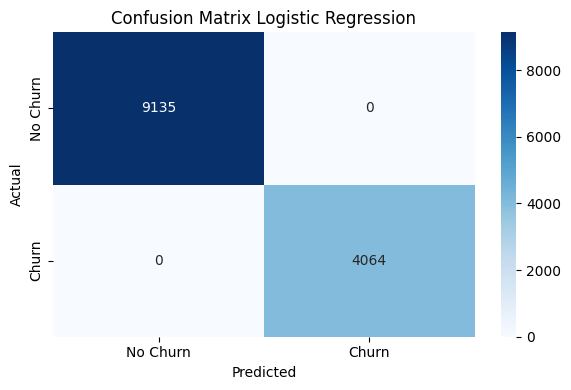

In [9]:
evaluate_model(final_model, X_test, y_test)

In [11]:

joblib.dump(final_model, "../models/final_churn_pipeline.pkl")

['../models/final_churn_pipeline.pkl']

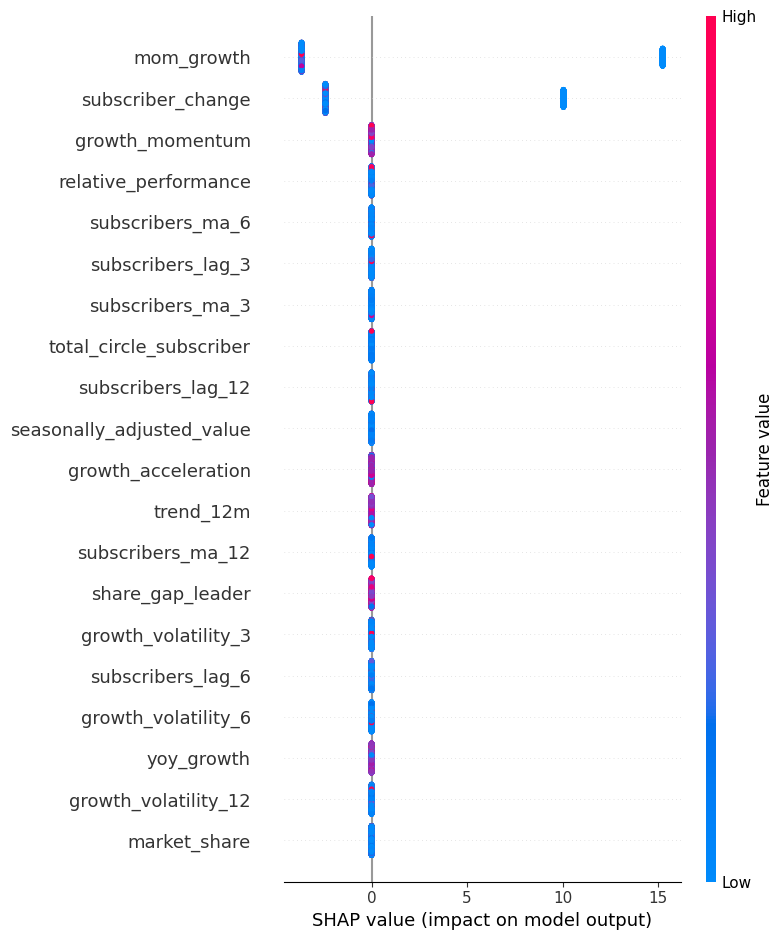

In [24]:
import shap

# Extract the trained model from your pipeline
gb_model = final_model.named_steps["gradientboostingclassifier"]

# Preprocess your test data
X_test_encoded = final_model.named_steps["onehotencoder"].transform(X_test)
X_test_scaled = final_model.named_steps["standardscaler"].transform(X_test_encoded)

# Create TreeExplainer
explainer = shap.TreeExplainer(gb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled[:1000])  # Limit to first 1000 samples for performance

# Visualize
shap.summary_plot(shap_values, X_test_scaled[:1000], feature_names=final_model.named_steps["onehotencoder"].get_feature_names_out())


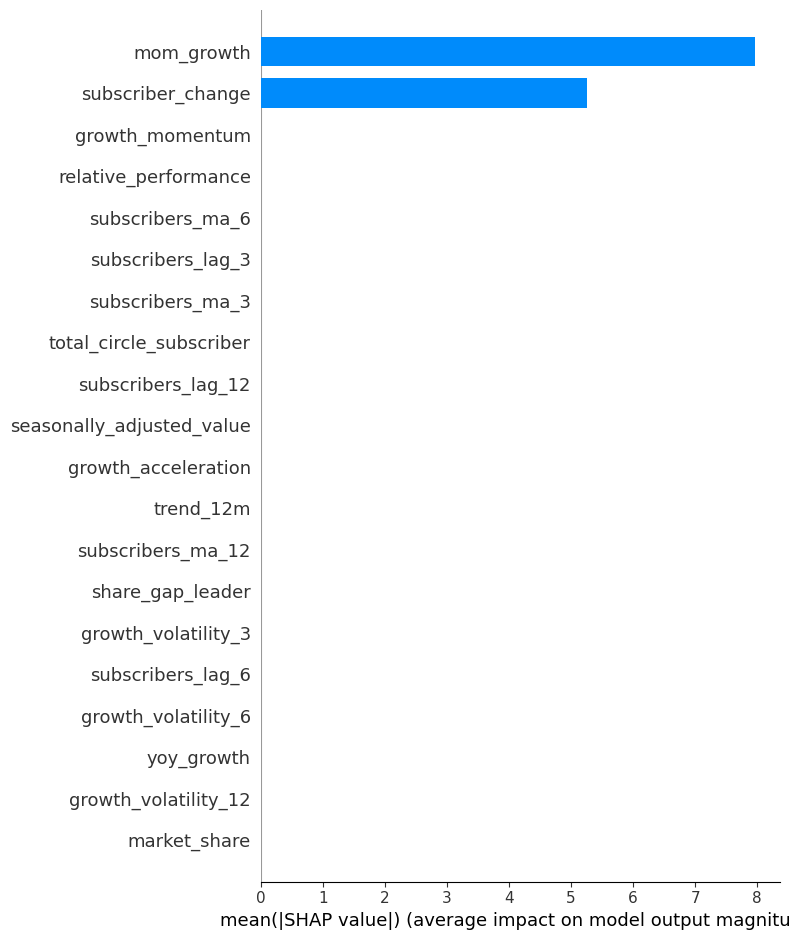

In [25]:
shap.summary_plot(shap_values, X_test_scaled[:1000], plot_type="bar", feature_names=final_model.named_steps["onehotencoder"].get_feature_names_out())

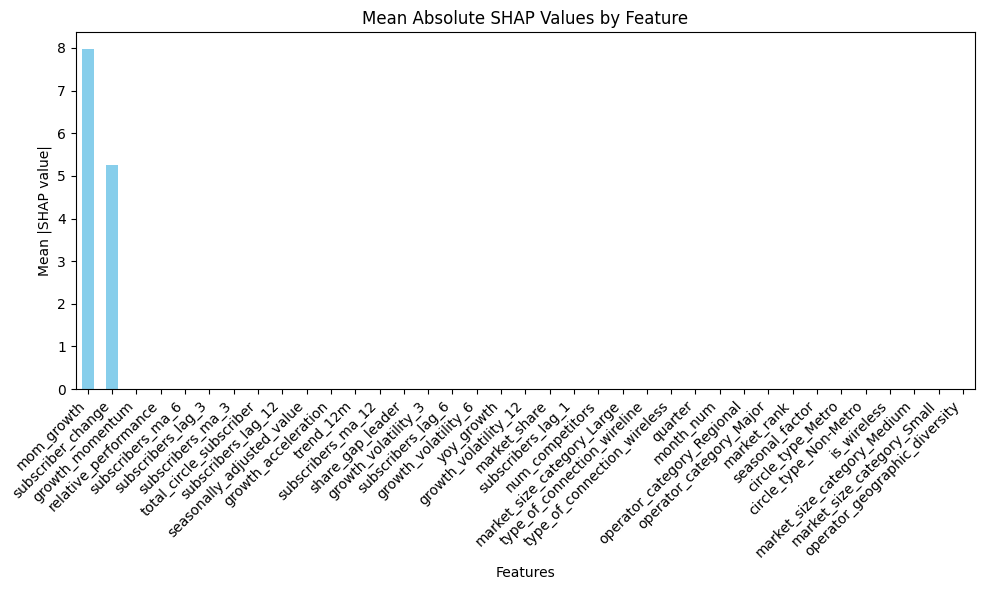

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feature_names=final_model.named_steps["onehotencoder"].get_feature_names_out()

# Take mean absolute SHAP value across all samples
mean_shap = np.abs(shap_values).mean(axis=0)

# Create Series with feature names
shap_series = pd.Series(mean_shap, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
shap_series.plot(kind='bar', color='skyblue')
plt.title("Mean Absolute SHAP Values by Feature")
plt.ylabel("Mean |SHAP value|")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
shap_series

mom_growth                       7.967973e+00
subscriber_change                5.252495e+00
growth_momentum                  2.647589e-17
relative_performance             1.854940e-17
subscribers_ma_6                 1.633134e-17
subscribers_lag_3                1.508862e-17
subscribers_ma_3                 1.387963e-17
total_circle_subscriber          1.260819e-17
subscribers_lag_12               1.118203e-17
seasonally_adjusted_value        1.020950e-17
growth_acceleration              1.020191e-17
trend_12m                        9.610775e-18
subscribers_ma_12                6.046379e-18
share_gap_leader                 5.580605e-18
growth_volatility_3              5.375908e-18
subscribers_lag_6                5.244503e-18
growth_volatility_6              4.947669e-18
yoy_growth                       4.376092e-18
growth_volatility_12             3.729764e-18
market_share                     2.746501e-18
subscribers_lag_1                2.989010e-19
num_competitors                  9